<a href="https://colab.research.google.com/github/anand-bidwalkar/SIT796-Reinforcement-Learning/blob/master/Task-4.2P/Task_4_2P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SIT-796 Reinforcement Learning Task-4.2P Monte Carlo On-Policy & Off-Policy**

In [1]:
import sys
import gym
import numpy as np
import random
from collections import defaultdict
import torch

In [48]:
# env
env = gym.make('Blackjack-v0')

off_policy_rewards = []
on_policy_rewards = []

Monte Carlo Off-Polcy Method

In [13]:
def get_random_policy(nA):  
    R = np.ones(nA, dtype=float) / nA
    def policy_fn(obs):
        return R
    return policy_fn

def get_greedy_policy(env,Q):
    def policy(obs):
        P = np.zeros_like(Q[obs], dtype=float)
        best_action = np.argmax(Q[obs])  
        P[best_action] = 1
        return P
    return policy

In [43]:
def off_policy(policy, env, num_episodes, gamma):
    
    
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    target_policy = get_greedy_policy(env, Q)
        
    for i_episode in range(1, (num_episodes + 1)):
        
        episode = []
        state = env.reset()
        for t in range(100):
            probs = target_policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            off_policy_rewards.append((i_episode, reward))
            if done:
                break
            state = next_state   
       
        G = 0.0
        W = 1.0
        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]
            G = gamma * G + reward
            C[state][action] += W            
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])            
            if action !=  np.argmax(target_policy(state)):
                break
            W = W * 1./policy(state)[action]
        
    return Q, target_policy

In [15]:
def calc_payoffs(env,rounds,players,pol):
    
    average_payouts = []
    for player in range(players):
        rd = 1
        total_payout = 0 
        while rd <= rounds:
            action = np.argmax(pol(env._get_obs()))
            obs, payout, is_done, _ = env.step(action)
            if is_done:
                total_payout += payout
                env.reset() 
                rd += 1
        average_payouts.append(total_payout)

    plt.plot(average_payouts)                
    plt.xlabel('num_player')
    plt.ylabel('reward after ' + str(rounds) + 'rounds')
    plt.show()    
    print ("Average reward of a player after {} rounds is {}".format(rounds, sum(average_payouts)/players))

In [49]:
env.reset()
rand = get_random_policy(env.action_space.n)
Q, policy = off_policy(rand, env, 500000, 0.9)

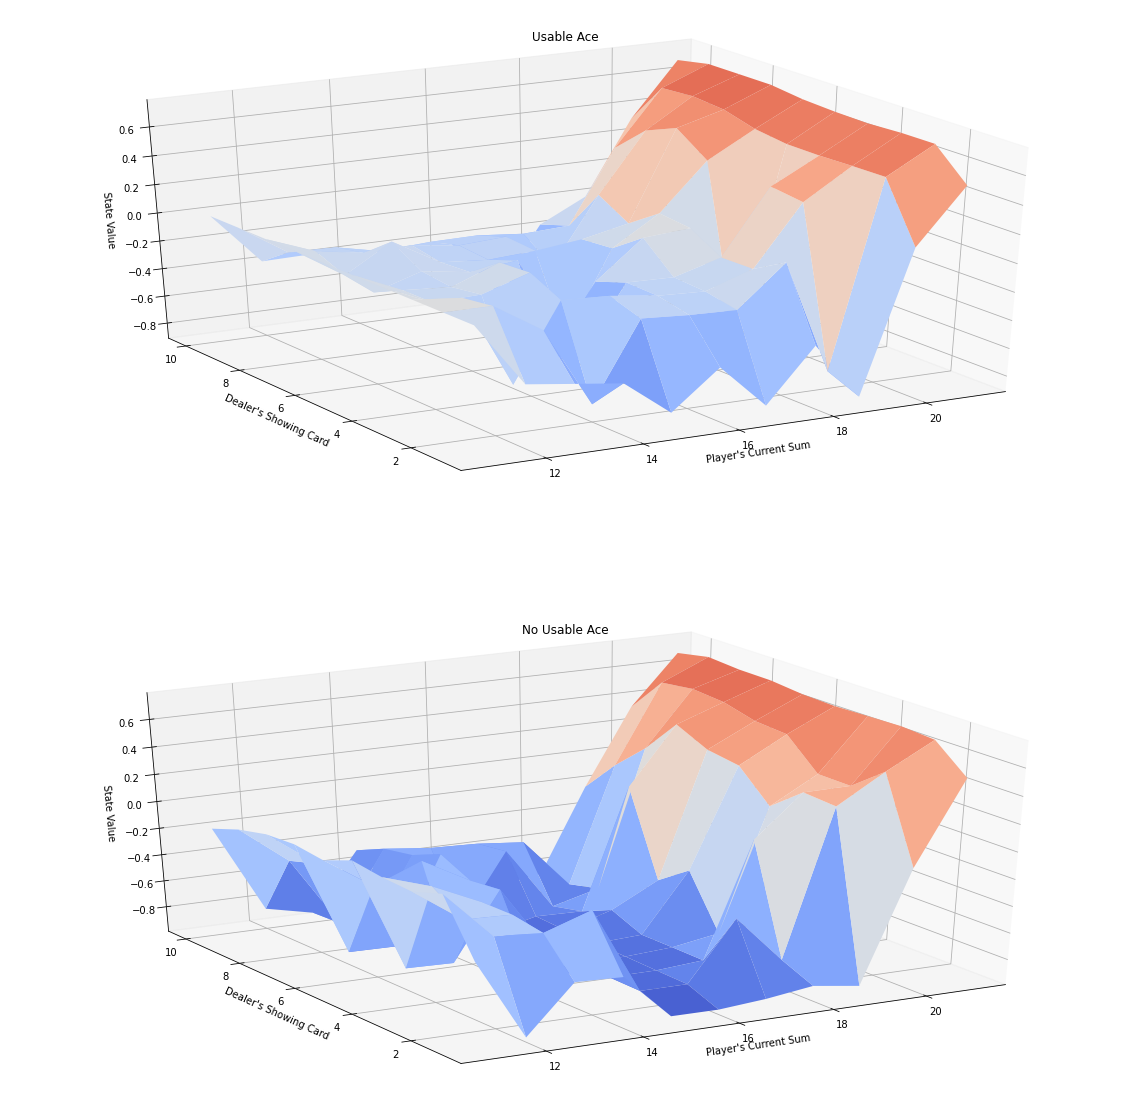

In [17]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()
    
# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

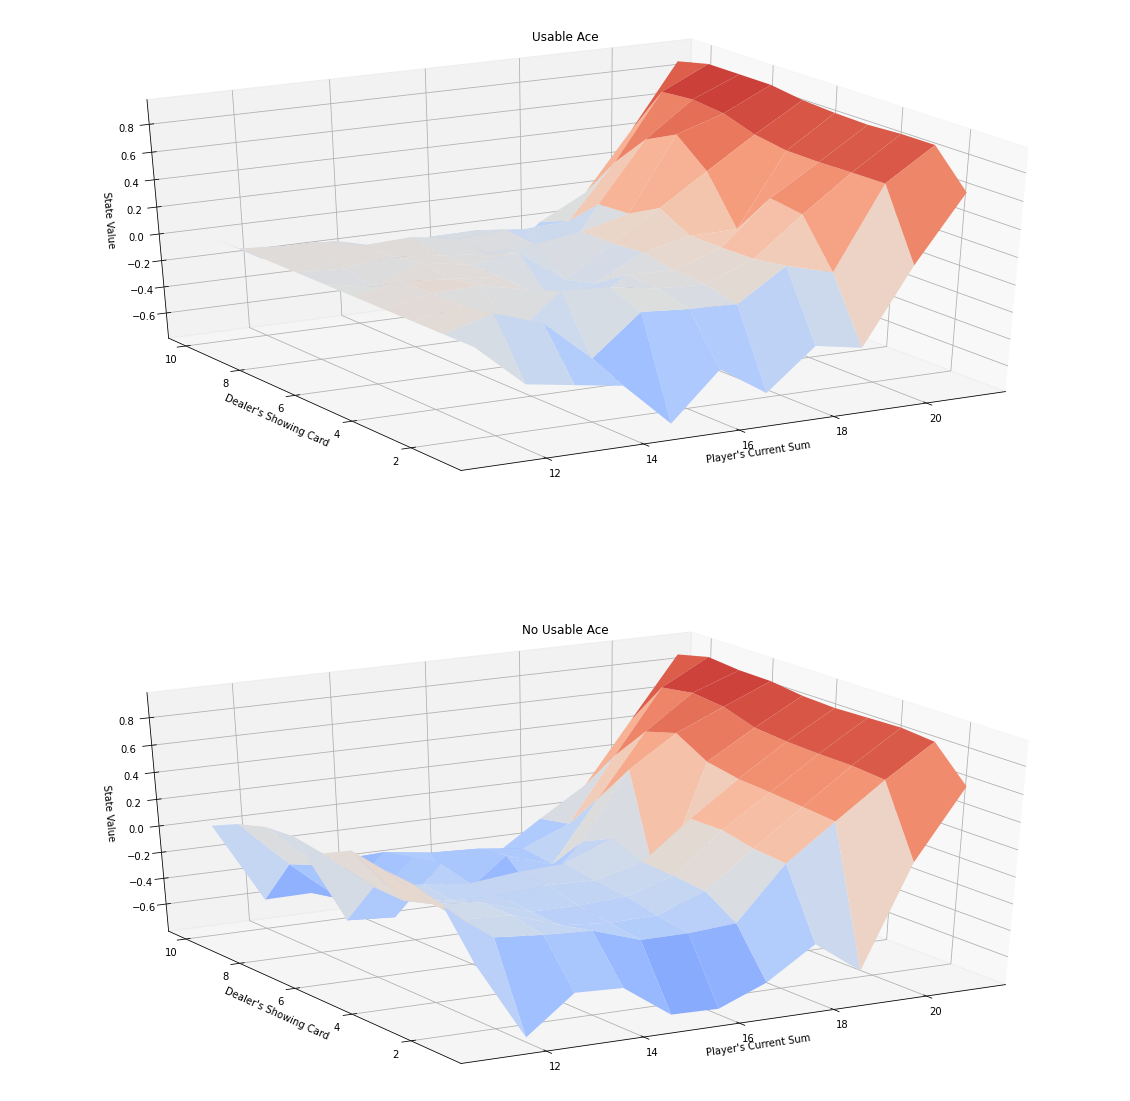

In [18]:
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value

plot_blackjack_values(V)

In [35]:
def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

Off-Policy MC Learning Policy


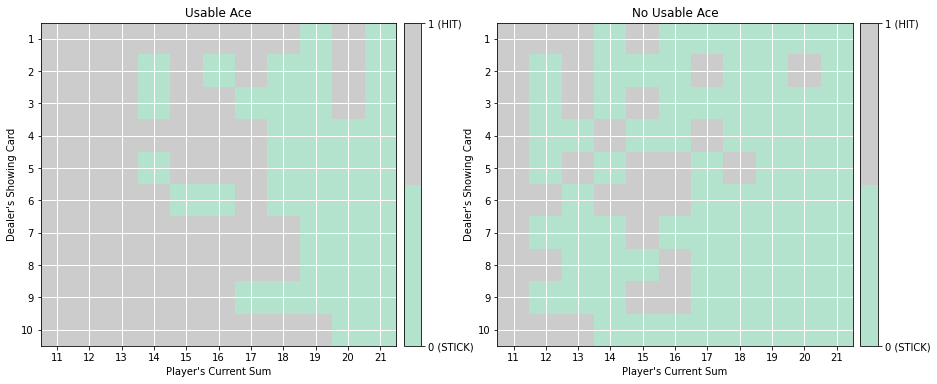

In [37]:
pol_test = {key: np.argmax(policy(key)) for key in Q.keys()}
plot_policy(pol_test)

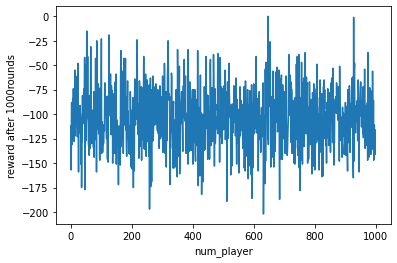

Average reward of a player after 1000 rounds is -103.916


In [19]:
import matplotlib
import matplotlib.pyplot as plt

env.reset()
calc_payoffs(env, 1000, 1000, policy)

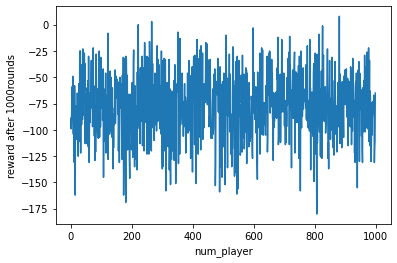

Average reward of a player after 1000 rounds is -77.072


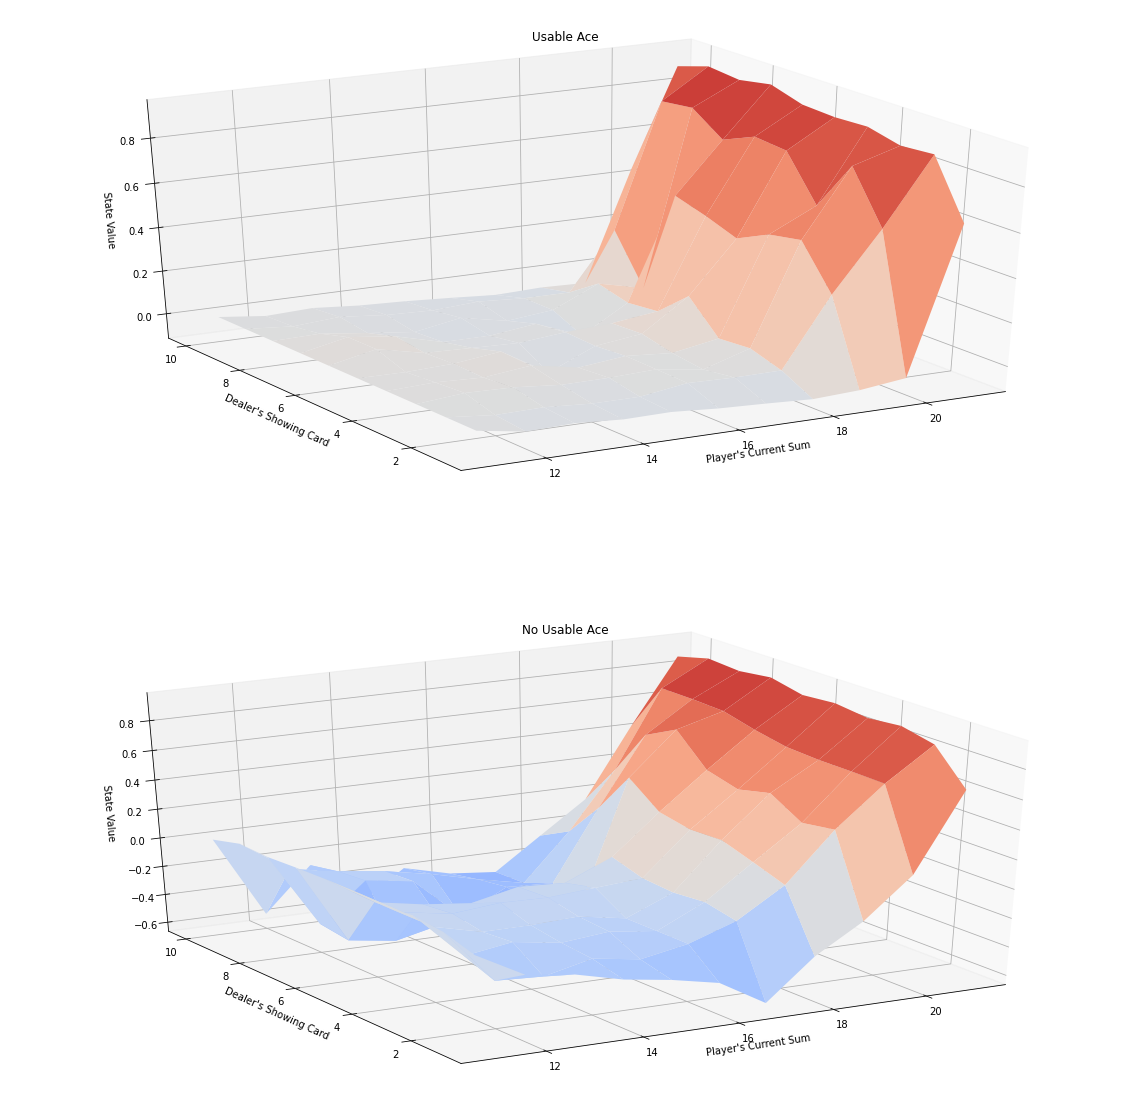

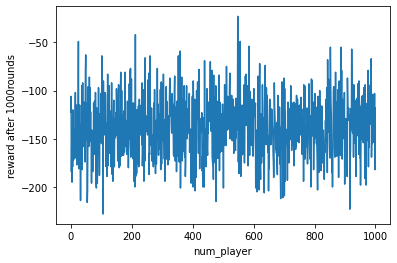

Average reward of a player after 1000 rounds is -138.207


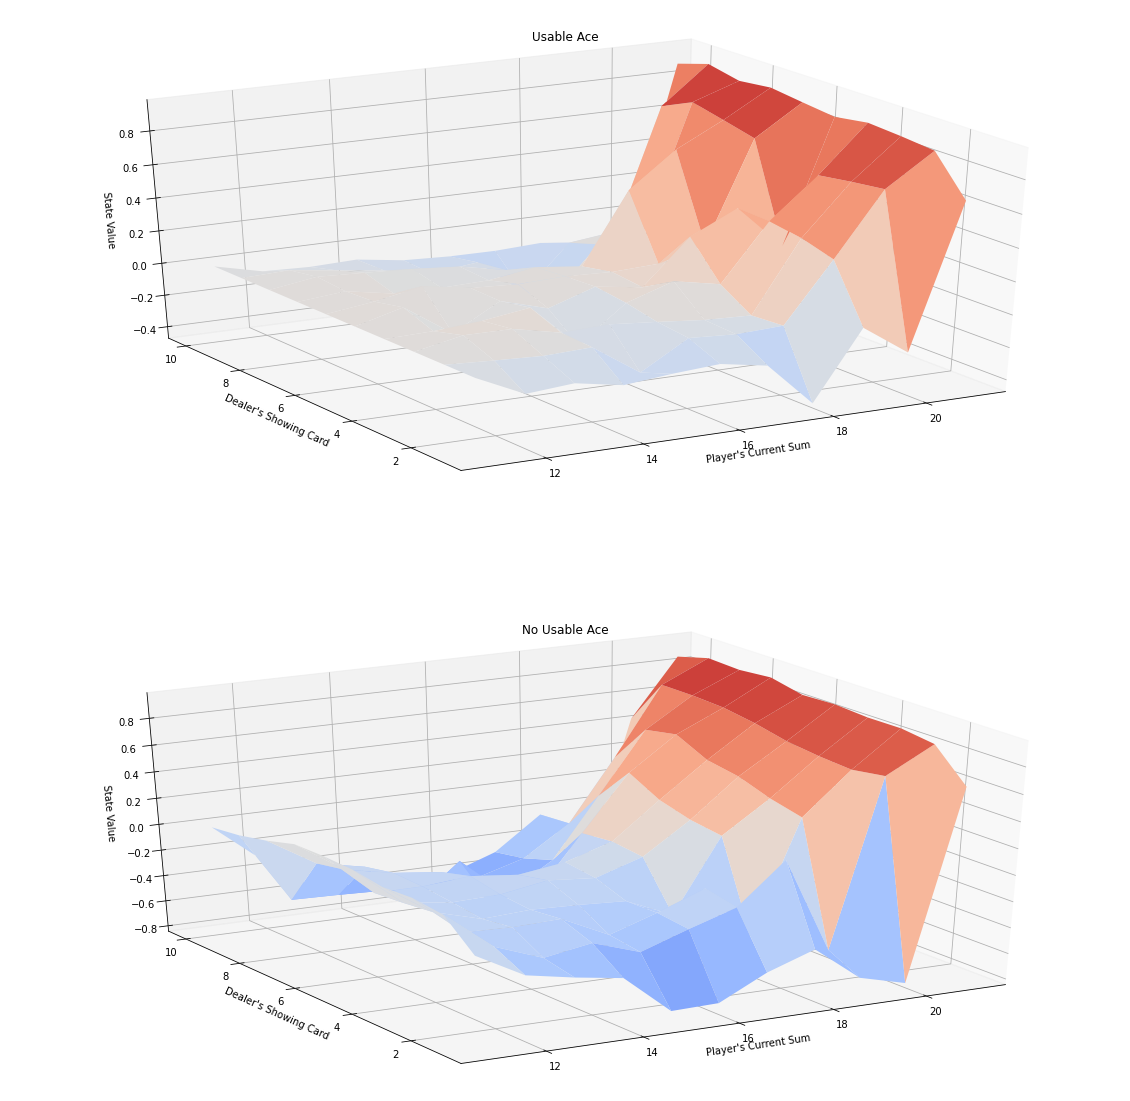

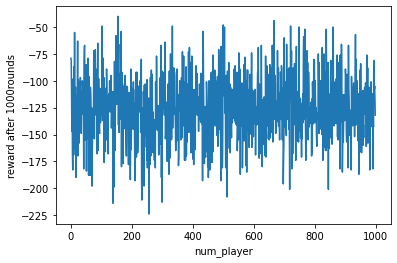

Average reward of a player after 1000 rounds is -125.392


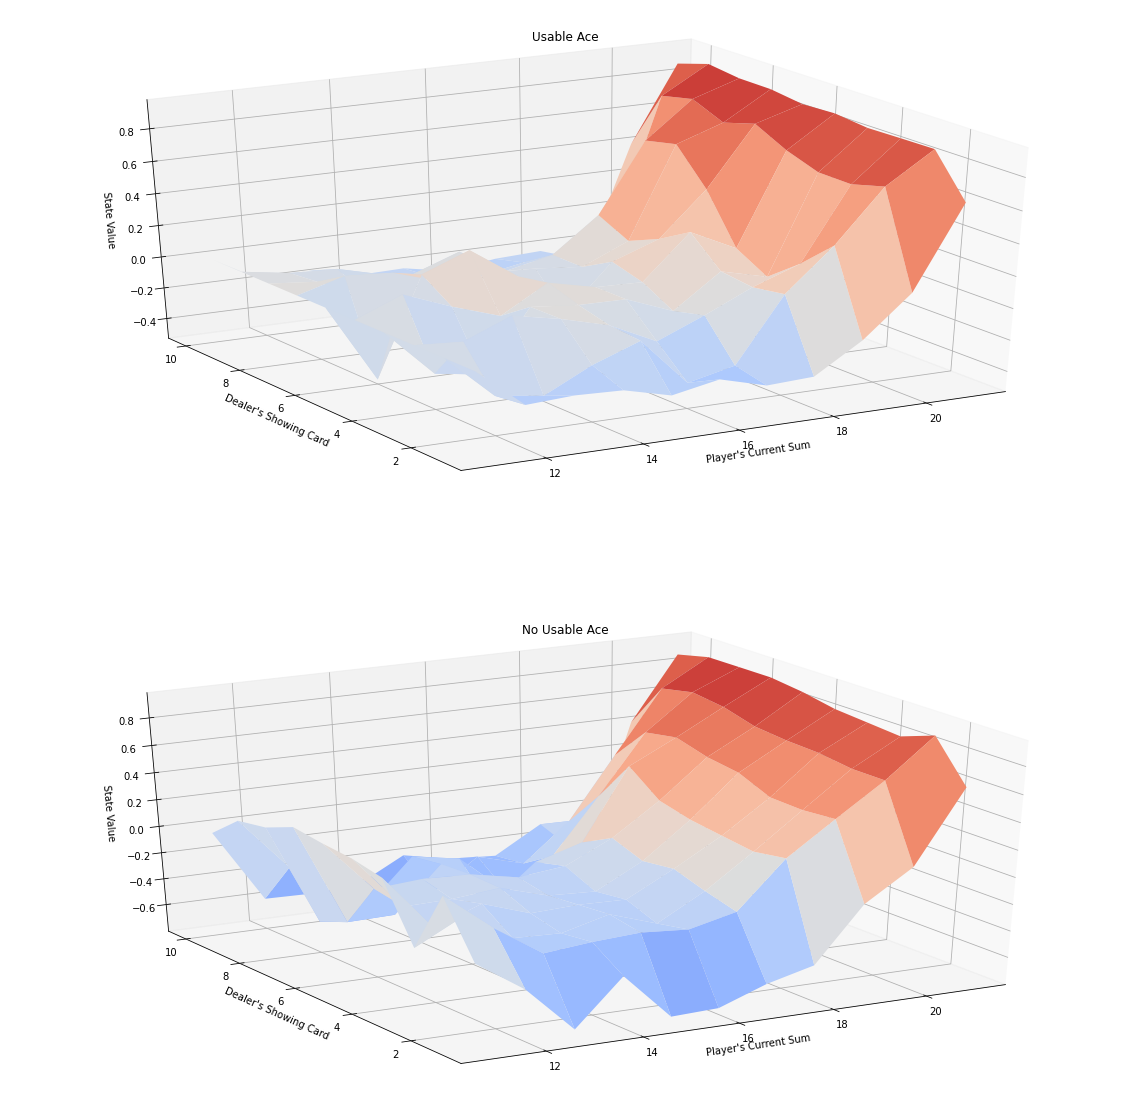

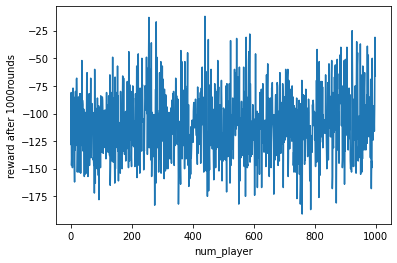

Average reward of a player after 1000 rounds is -110.469


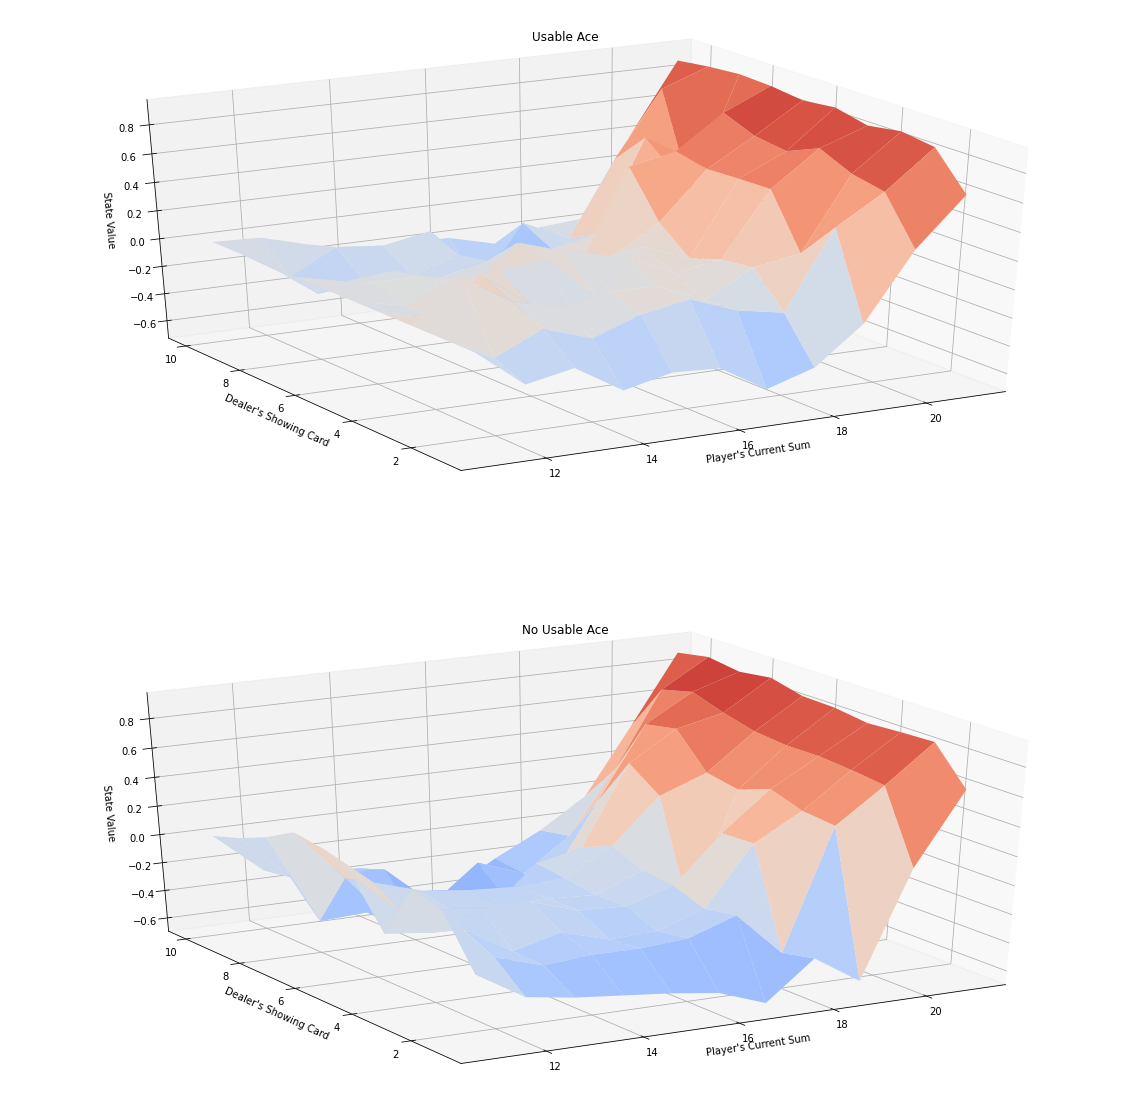

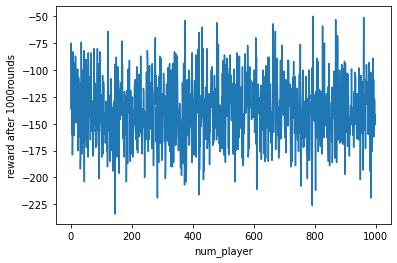

Average reward of a player after 1000 rounds is -137.304


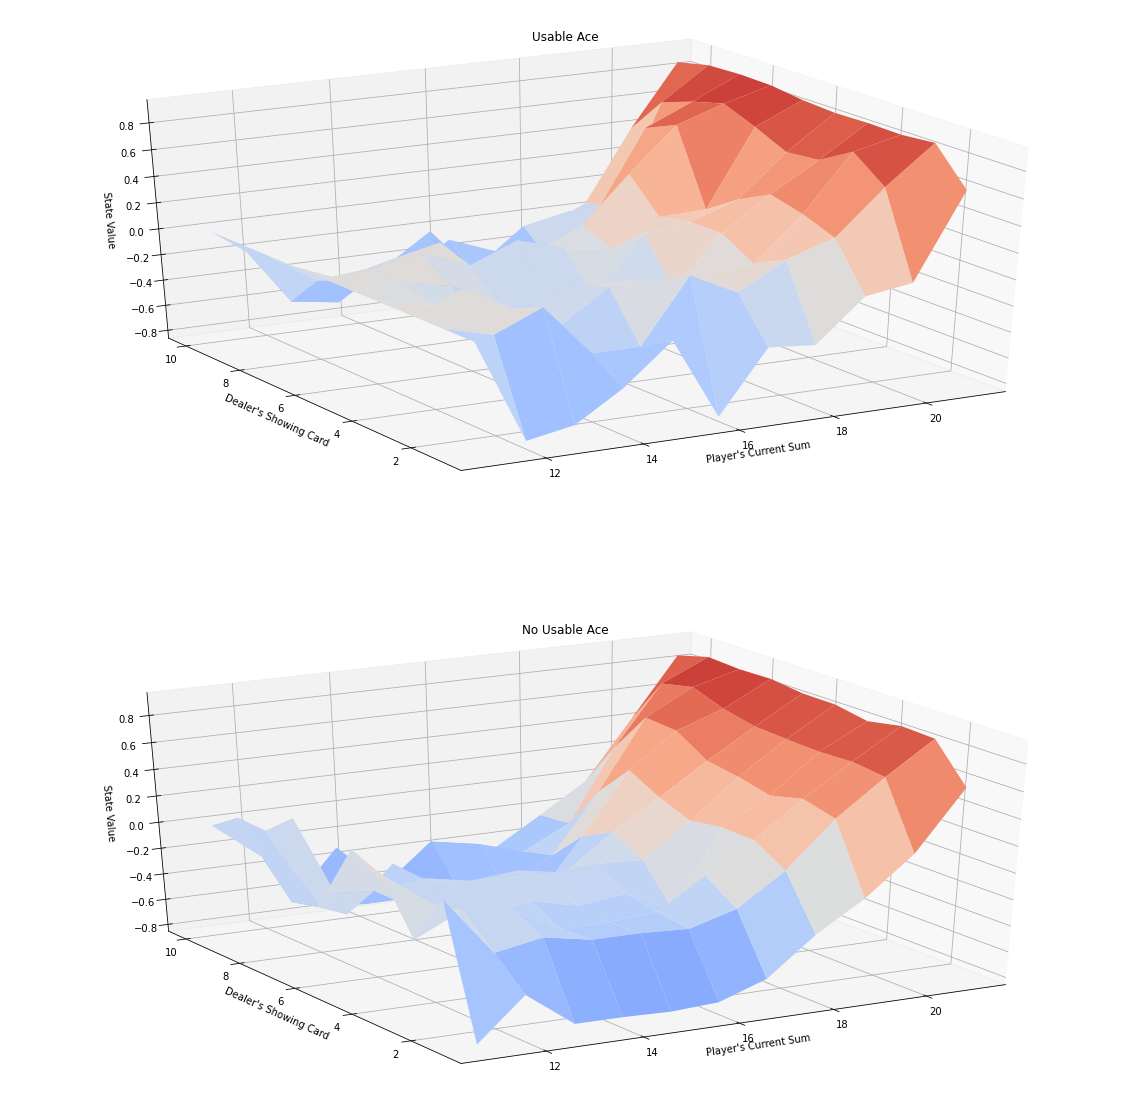

In [20]:
r = [0.3, 0.5, 0.8, 0.9, 1.0]
for g in r:
  env.reset()
  re = get_random_policy(env.action_space.n)
  Q, policy = mc_prediction(re, env, 100000, g)
  calc_payoffs(env, 1000, 1000, policy)
  V = defaultdict(float)
  for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value

  plot_blackjack_values(V)

On-Policy

In [27]:
def create_epsilon_greedy_action_policy(env,Q,epsilon):
    def policy(obs):
        P = np.ones(env.action_space.n, dtype=float) * epsilon / env.action_space.n  #initiate with same prob for all actions
        best_action = np.argmax(Q[obs])  #get best action
        P[best_action] += (1.0 - epsilon)
        return P
    return policy

In [57]:
def on_policy(env, episodes, discount_factor, epsilon):

    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    pol = create_epsilon_greedy_action_policy(env,Q,epsilon)
    
    for i in range(1, episodes + 1):
        if i% 1000 == 0:
            print("\rEpisode {}/{}.".format(i, episodes), end="")

        episode = []
        state = env.reset()
        for t in range(100):
            probs = pol(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            on_policy_rewards.append((i, reward))
            if done:
                break
            state = next_state

        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
    
    return Q, pol

In [59]:
on_policy_rewards = []
Q_on_pol, On_learned_policy = on_policy(env, 500000, 0.9, 0.05)

Episode 500000/500000.

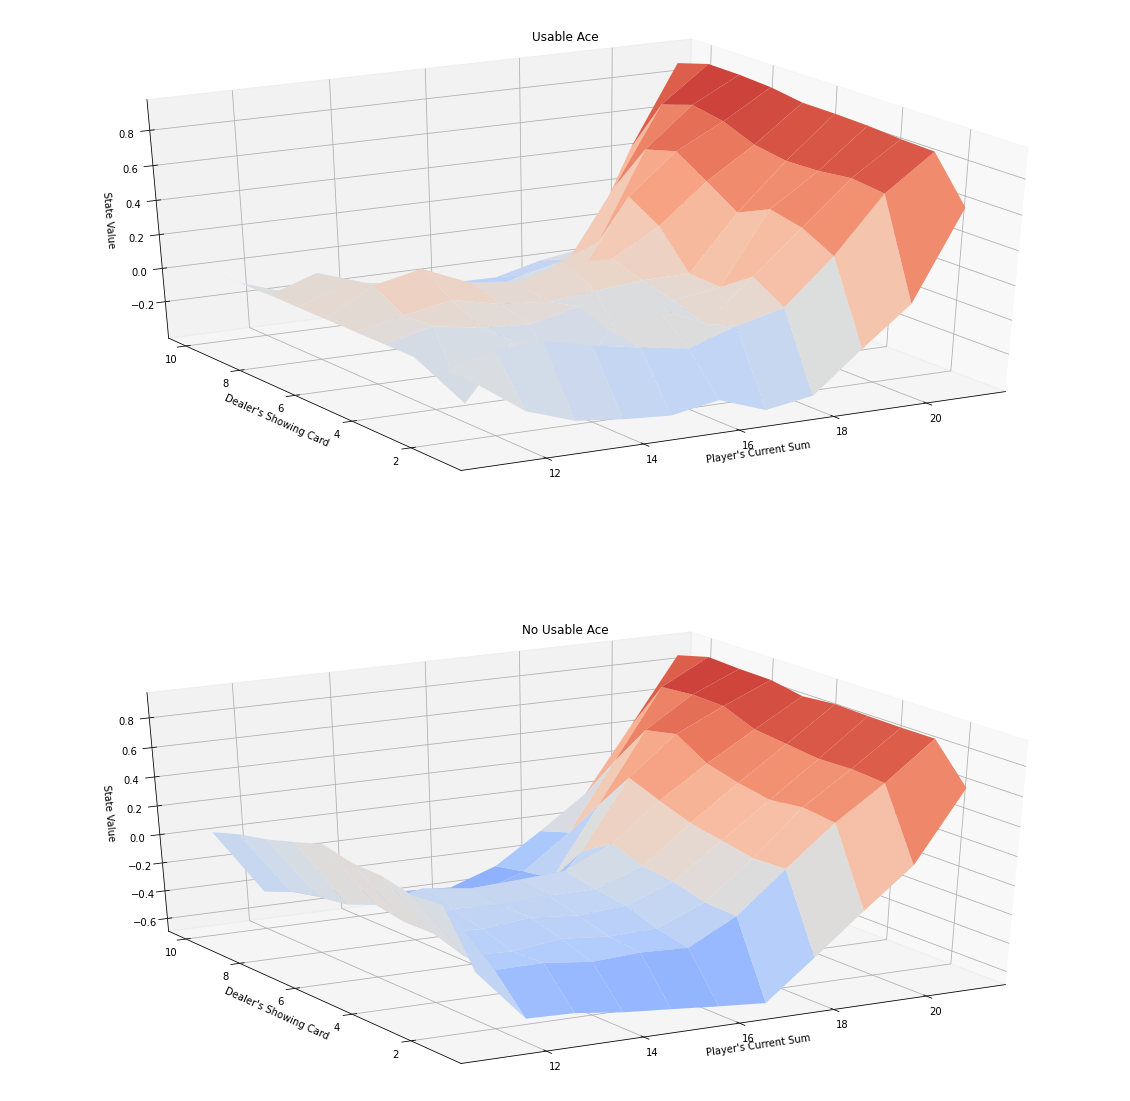

In [32]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q_on_pol.items())

# plot the state-value function
plot_blackjack_values(V)

In [60]:
# off policy reward formatting/cummulative
off_Rx =  [x for x, y in off_policy_rewards]
off_Ry = [y for x, y in off_policy_rewards]
off_Ry = np.cumsum(off_Ry)
off_Ry = off_Ry.tolist()

# on policy reward formatting/cummulative
on_Rx =  [x for x, y in on_policy_rewards]
on_Ry = [y for x, y in on_policy_rewards]
on_Ry = np.cumsum(on_Ry)
on_Ry = on_Ry.tolist()

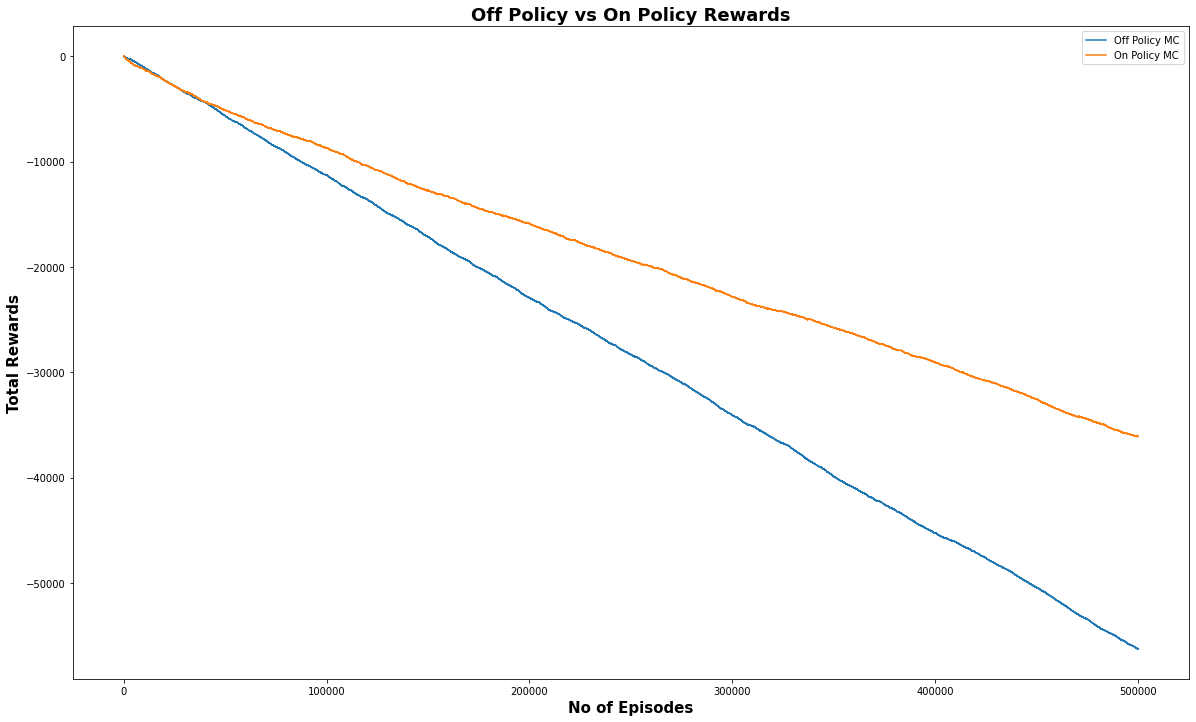

In [61]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,12))
plt.title('Off Policy vs On Policy Rewards', size=18, fontweight='bold')
plt.xlabel('No of Episodes', size=15, fontweight='bold')
plt.ylabel('Total Rewards', size=15, fontweight='bold')
plt.plot(np.array(off_Rx), np.array(off_Ry), label='Off Policy MC')
plt.plot(np.array(on_Rx), np.array(on_Ry), label='On Policy MC')
plt.legend()
plt.show()